In [221]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv


In [222]:
#Importing necessary libraries for initial analysis
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats
from scipy.stats import norm, skew
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.special import boxcox1p
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import NotFittedError
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [223]:
df_train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# Data Exploration 

Data in Tabulated form

In [224]:
df_train.head()
Id = df_test['Id']
print(df_train.shape)

(1460, 81)


Lets first see how sales price is distributed

In [225]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [226]:
#Skewness
print('Sale Price Skewness = ',df_train['SalePrice'].skew())
#Kurtosis
print('Sale Price Kurtosis = ',df_train['SalePrice'].kurtosis())

Sale Price Skewness =  1.8828757597682129
Sale Price Kurtosis =  6.536281860064529


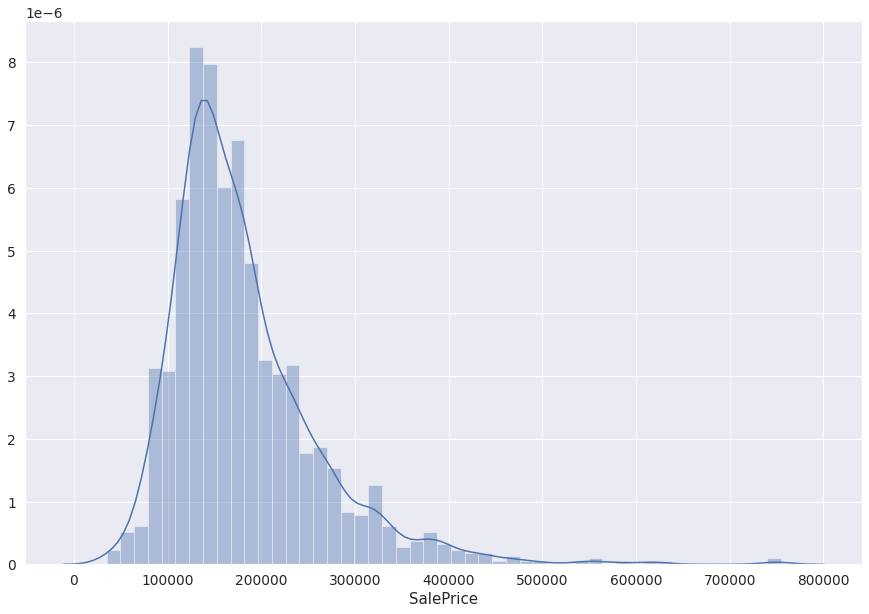

In [227]:
plt.figure(figsize=(15,10))
sns.distplot(df_train.SalePrice)

From the distplot it seem that salesprice is left skewed and needs to be normalized

Moving on lets see the Sale Price relationship with 
* 'GrLivArea' 
* 'TotalBsmtSF'

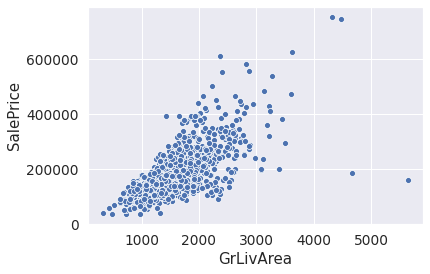

In [228]:
# Scatter plot Saleprice and GrliveArea
sns.scatterplot(x = 'GrLivArea', y = 'SalePrice' , data = df_train)

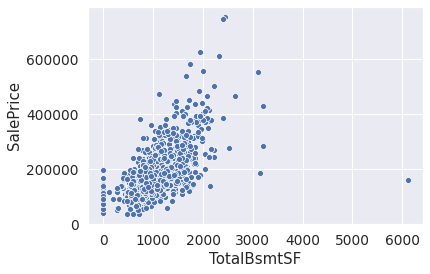

In [229]:
# Scatter plot Saleprice and TotalBsmtSF
sns.scatterplot(x = 'TotalBsmtSF', y = 'SalePrice' , data = df_train)

From the above visulaization it is clear that:-
1. GrliveArea have a linear relationship with Sale price with some outliers 
2. TotalBsmtSF have a Exponential relationship with Sale price with some outliers 

# Further Exploration 

OverallQual Vs SalePrice 

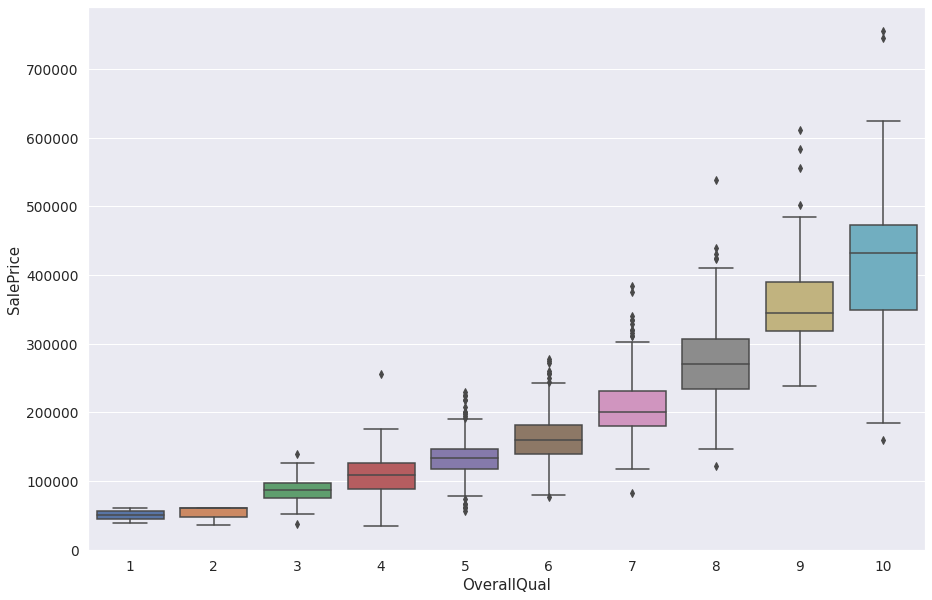

In [230]:
plt.figure(figsize=(15,10))
sns.boxplot(y = 'SalePrice', x = 'OverallQual', data = df_train)

Year Vs Sale Price 

(-0.5, 111.5, 0.0, 791005.0)

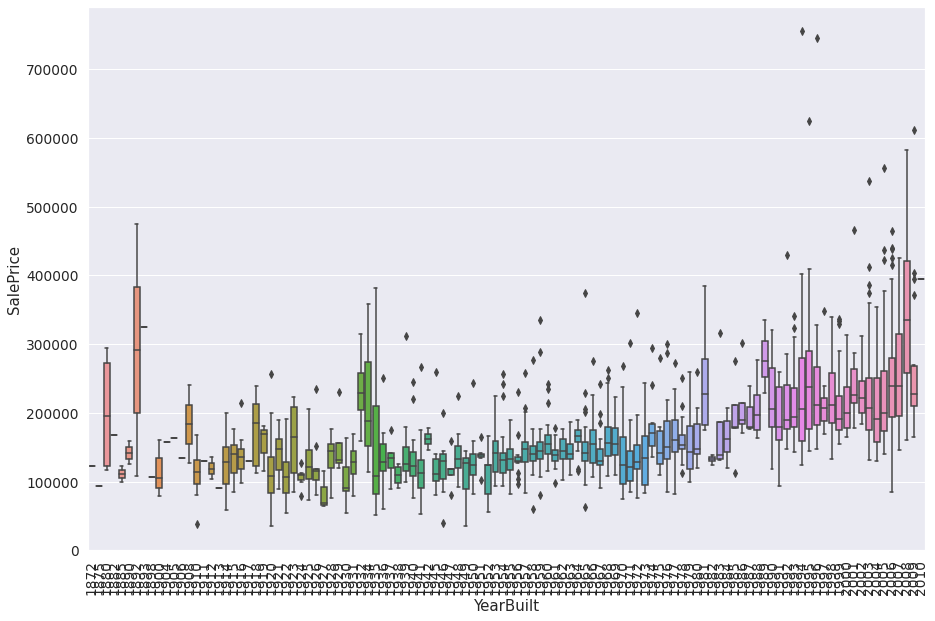

In [231]:
plt.figure(figsize=(15,10))
sns.boxplot(y = 'SalePrice', x = 'YearBuilt', data = df_train)
plt.xticks(rotation=90)
plt.axis(ymin=0, y=800000)

Lets find the correlation of different variables with Sale price 

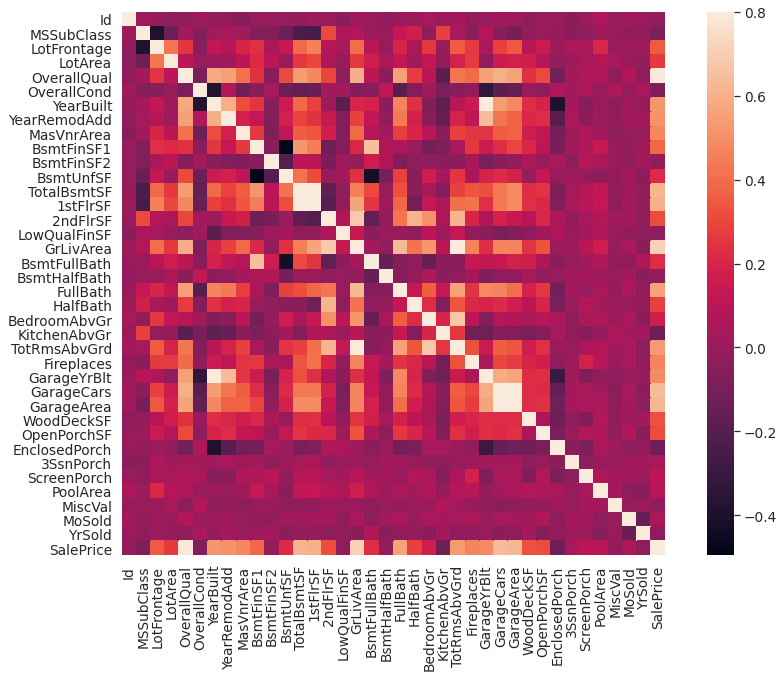

In [232]:
#Correlation with Sale Price 
corr = df_train.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr,vmax=.8, square=True)

Now further analyze the largest effecting variable on the total sale price 

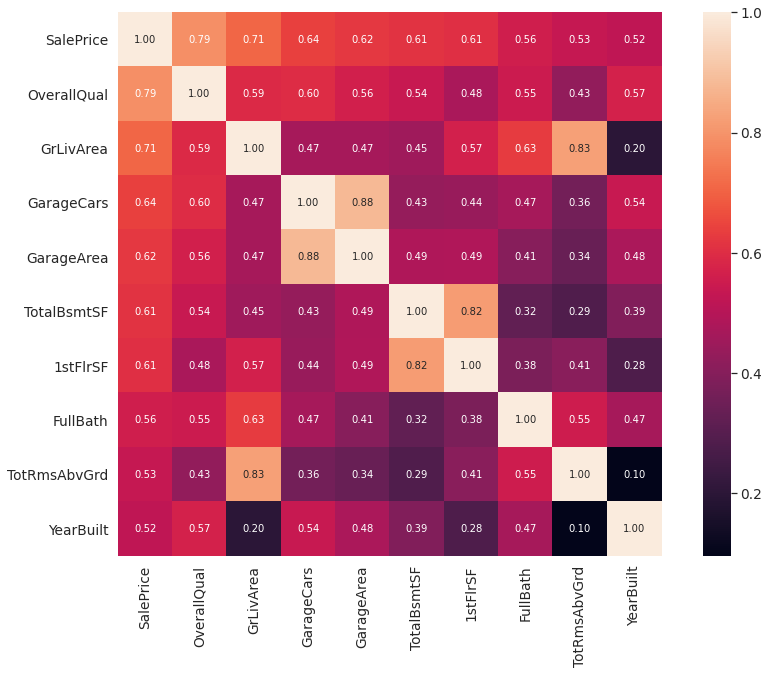

In [233]:
#saleprice correlation matrix
plt.figure(figsize=(15,10))
k = 10 #number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


Above mentioned variable looks to be affecting most the total sale price but still it doesnt mean we can reject the other variable. 

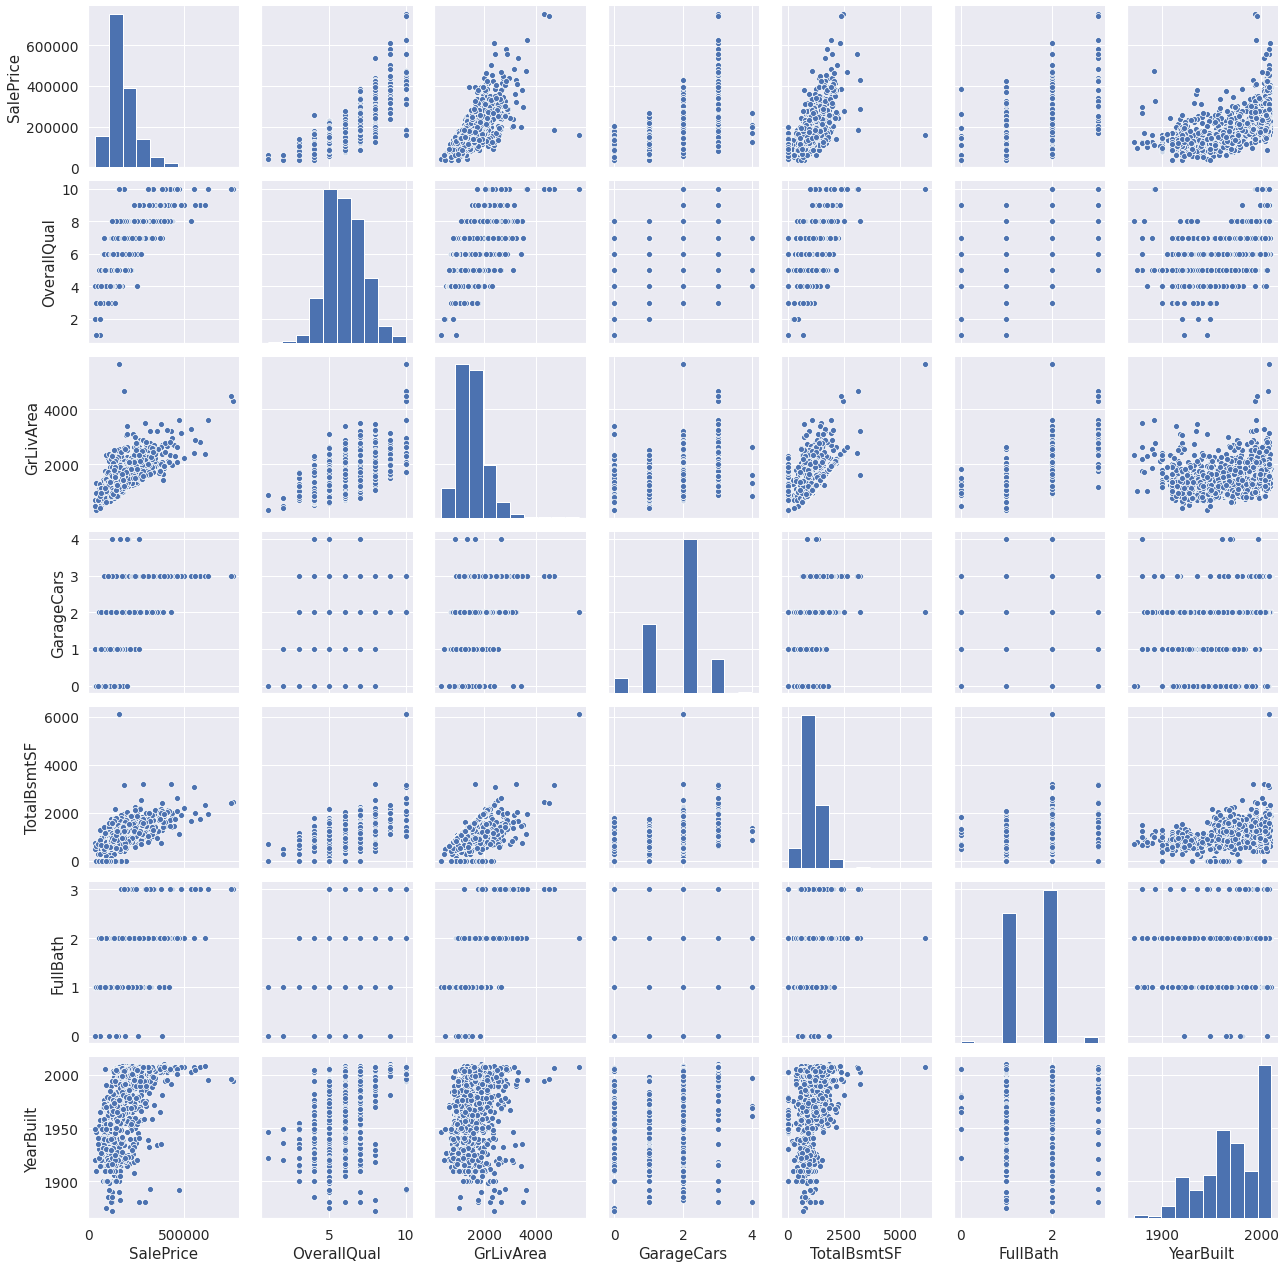

In [234]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 
        'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols])

The above pair plot give us a conclusive understanding of the variable that are most correlated with the sale price.

# Data Cleaning

Lets first normalize the sales price which is skewed using log.


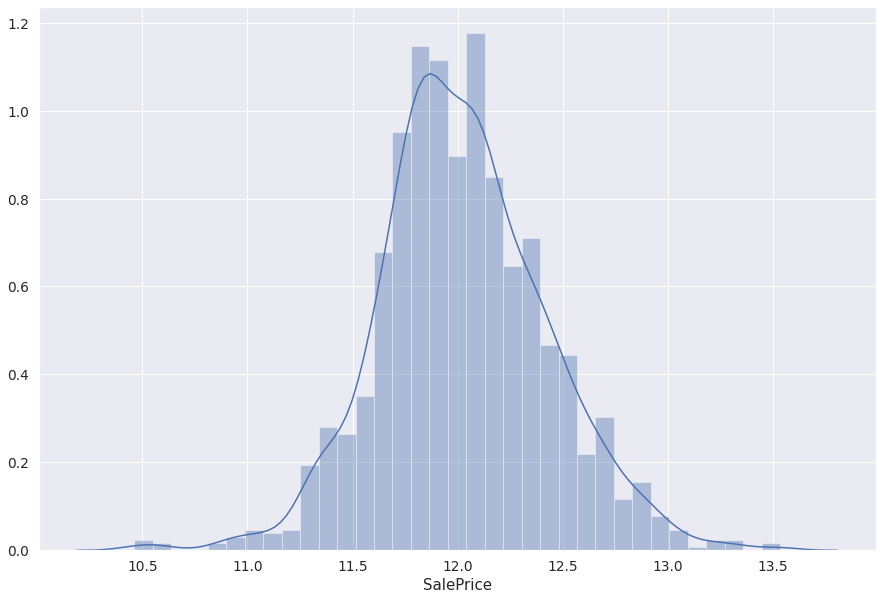

In [235]:
#Normalizing Sale price 
df_train.SalePrice  = np.log1p(df_train.SalePrice)
plt.figure(figsize=(15,10))
sns.distplot(df_train.SalePrice)

Revmoving outlier in GrlivArea and TotalBSMT


In [236]:
#Outlier in GrlivArea
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000)&(df_train['SalePrice']<12.5)].index)


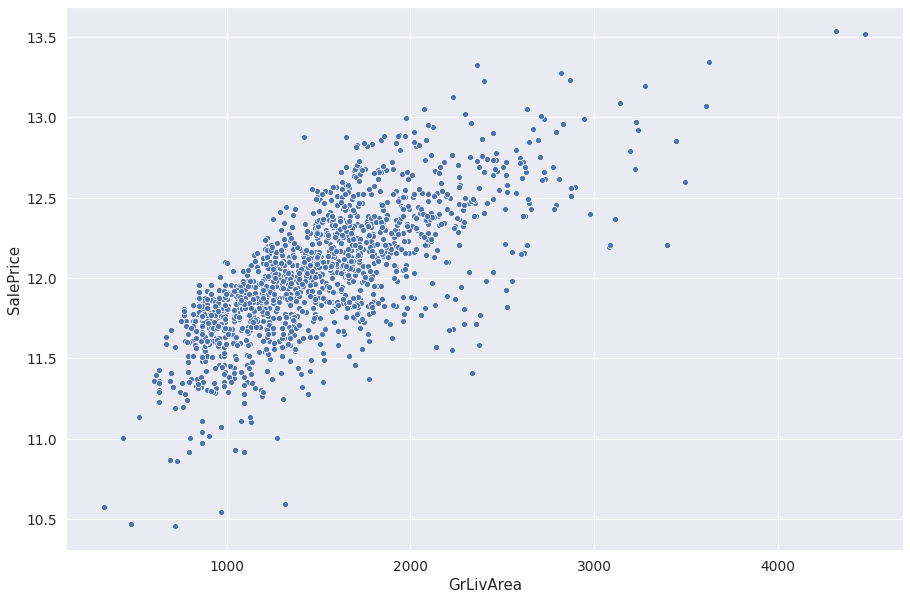

In [237]:
plt.figure(figsize=(15,10))
sns.scatterplot(x = 'GrLivArea', y = 'SalePrice' , data = df_train)

Now lets see what % of data is missing in columns.

In [238]:
#Missing Train data
missing_total = df_train.isnull().sum().sort_values(ascending=False)
miss_pre = ((df_train.isnull().sum() / df_train.isnull().count()) * 100).sort_values(ascending=False)
missing = pd.concat([missing_total,miss_pre], axis=1, keys=['Total', 'Percent'])
missing.head(20)

,Total,Percent
PoolQC,1452,99.588477
MiscFeature,1404,96.296296
Alley,1367,93.758573
Fence,1177,80.727023
FireplaceQu,690,47.325103
LotFrontage,259,17.764060
GarageCond,81,5.555556
GarageType,81,5.555556
GarageYrBlt,81,5.555556
GarageFinish,81,5.555556


Text(0.5, 1.0, 'Missing Train Data')

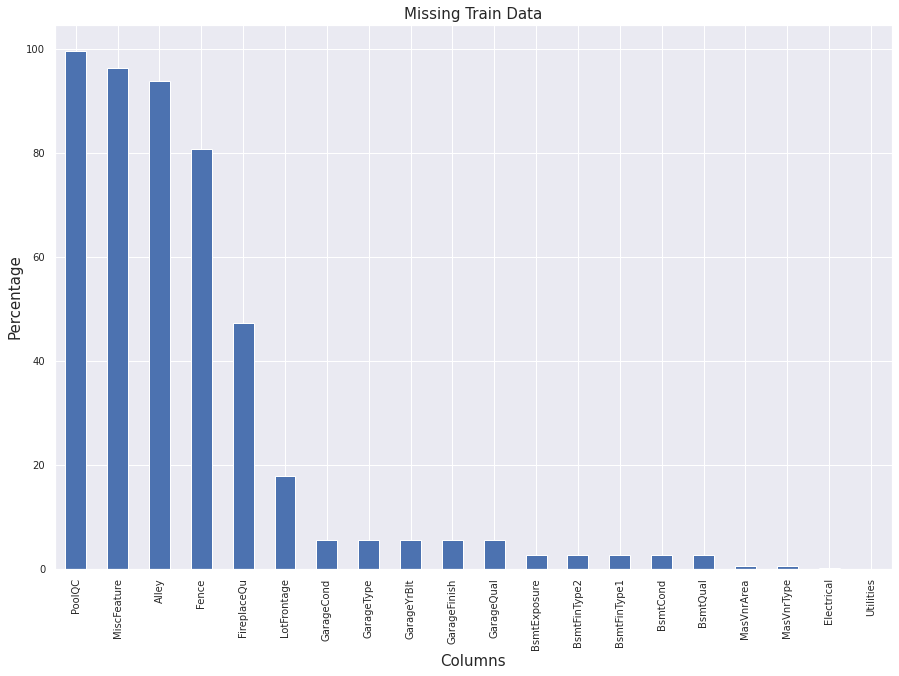

In [239]:
missing = missing.head(20)
plt.figure(figsize=(15,10))
missing['Percent'].plot(kind="bar", fontsize = 10)
plt.xlabel('Columns')
plt.ylabel('Percentage')
plt.title('Missing Train Data')

In [240]:
#Missing Test data
missing_total = df_test.isnull().sum().sort_values(ascending=False)
miss_pre_test = ((df_test.isnull().sum() / df_test.isnull().count()) * 100).sort_values(ascending=False)
missing_test = pd.concat([missing_total,miss_pre], axis=1, keys=['Total', 'Percent'])
missing_test.head(20)

,Total,Percent
PoolQC,1456.0,99.588477
MiscFeature,1408.0,96.296296
Alley,1352.0,93.758573
Fence,1169.0,80.727023
FireplaceQu,730.0,47.325103
LotFrontage,227.0,17.764060
GarageCond,78.0,5.555556
GarageQual,78.0,5.555556
GarageYrBlt,78.0,5.555556
GarageFinish,78.0,5.555556


Text(0.5, 1.0, 'Missing Test Data')

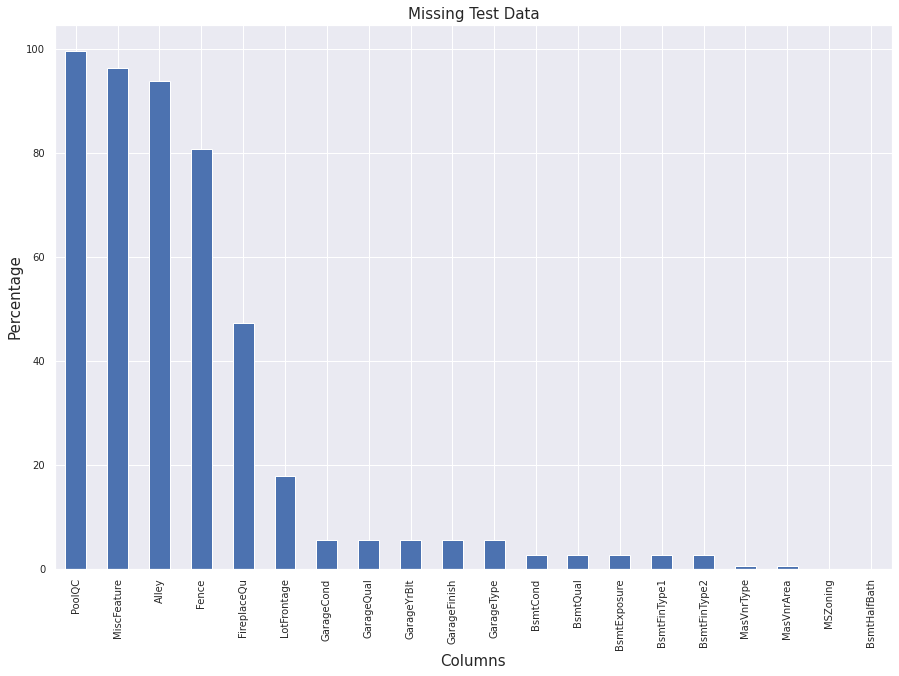

In [241]:
#Test data
missing_test = missing_test.head(20)
plt.figure(figsize=(15,10))
missing_test['Percent'].plot(kind="bar", fontsize = 10)
plt.xlabel('Columns')
plt.ylabel('Percentage')
plt.title('Missing Test Data')

Remove the id column in both test and train as is irrelevant to calculation

In [242]:
# ID drop Train
df_train = df_train.drop('Id',1)
print(df_train.shape)
# ID drop Test
df_test = df_test.drop(['Id'],1)
print(df_test.shape)

(1458, 80)
(1459, 79)


Now we combine all the data for further preprocessing 

In [243]:
#combine Data to increase amount of data for analysis
combine = pd.concat([df_train,df_test], ignore_index=True)
combine.shape

(2917, 80)

In [244]:
# Separate target variable 
Y = df_train['SalePrice']
df = combine.drop(['SalePrice'], axis = 1)
print(Y.shape)
print(df.shape)

(1458,)
(2917, 79)


Remove column having < 40%  null data.

In [245]:
#Missing Test data
missing_total = df.isnull().sum().sort_values(ascending=False)
miss_pre_test = ((df.isnull().sum() / df.isnull().count()) * 100).sort_values(ascending=False)
missing_test = pd.concat([missing_total,miss_pre], axis=1, keys=['Total', 'Percent'])
missing_test.head(20)

,Total,Percent
PoolQC,2908.0,99.588477
MiscFeature,2812.0,96.296296
Alley,2719.0,93.758573
Fence,2346.0,80.727023
FireplaceQu,1420.0,47.325103
LotFrontage,486.0,17.764060
GarageCond,159.0,5.555556
GarageQual,159.0,5.555556
GarageYrBlt,159.0,5.555556
GarageFinish,159.0,5.555556


In [246]:
#40% > column removal 
df = df.drop(['PoolQC', 'MiscFeature','Alley', 'Fence','FireplaceQu'], 1)
df.shape

(2917, 74)

In [247]:
#Find the types of data in column 
df.dtypes.value_counts()

object     38
int64      25
float64    11
dtype: int64

In [248]:
df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)

GarageCond       159
GarageQual       159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MSZoning           4
Utilities          2
Functional         2
Electrical         1
KitchenQual        1
SaleType           1
Exterior2nd        1
Exterior1st        1
LandContour        0
BldgType           0
LotShape           0
LotConfig          0
LandSlope          0
Street             0
Neighborhood       0
Condition1         0
Condition2         0
SaleCondition      0
HouseStyle         0
RoofStyle          0
RoofMatl           0
ExterQual          0
Foundation         0
Heating            0
HeatingQC          0
CentralAir         0
PavedDrive         0
ExterCond          0
dtype: int64

In [249]:
#Fill missing values with None
cols1 = ["GarageQual","GarageCond", "GarageFinish", "GarageType", "BsmtExposure", 
         "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1","MasVnrType","GarageYrBlt"]
for col in cols1:
    df[col].fillna("None", inplace=True)

In [250]:
#Fill these values with 0 as already many present
cols=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", 
      "BsmtFinSF1", "GarageArea"]
for col in cols:
    df[col].fillna(0, inplace=True)

In [251]:
# fill in with mode
cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", 
         "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [252]:
#For numeric data:
df.select_dtypes(include = ['int','float']).isnull().sum().sort_values(ascending=False)

LotFrontage      486
YrSold             0
BsmtFinSF1         0
LowQualFinSF       0
2ndFlrSF           0
1stFlrSF           0
TotalBsmtSF        0
BsmtUnfSF          0
BsmtFinSF2         0
MasVnrArea         0
BsmtFullBath       0
YearRemodAdd       0
YearBuilt          0
OverallCond        0
OverallQual        0
LotArea            0
GrLivArea          0
BsmtHalfBath       0
MoSold             0
WoodDeckSF         0
MiscVal            0
PoolArea           0
ScreenPorch        0
3SsnPorch          0
EnclosedPorch      0
OpenPorchSF        0
GarageArea         0
FullBath           0
GarageCars         0
Fireplaces         0
TotRmsAbvGrd       0
KitchenAbvGr       0
BedroomAbvGr       0
HalfBath           0
MSSubClass         0
dtype: int64

Lot Area is divided on the basis of neighbourhood

In [253]:
# Now for lot area. We assume that each neighbourhood has same lot area 
df['LotFrontage'] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

Now we will convert numeric column to strings that appears to be categorical in nature and values.

In [254]:
#Conversion numeric to string
Num_Str = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr",
           "KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF",
           "GarageYrBlt"]
for col in Num_Str:
    df[col]=df[col].astype(str)

In [255]:
#All clean
print(df.shape)

(2917, 74)


# Feature Engineering

Now lets get the dummies variables and apply PCA.

In [256]:
#Getting dummies variable 
df = pd.get_dummies(df)
df.shape 

(2917, 640)

In [257]:
#Applying PCA 
pca = PCA(whiten = True)
pca.fit(df)
variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
cumulative_explained_variance 

array([0.97506532, 0.98252271, 0.98802669, 0.99298357, 0.99727732,
       0.99815662, 0.99869926, 0.99919279, 0.9995567 , 0.99978068,
       0.99984806, 0.99990734, 0.99995501, 0.99997325, 0.99998436,
       0.99999443, 0.99999966, 0.99999969, 0.99999971, 0.99999972,
       0.99999973, 0.99999974, 0.99999975, 0.99999976, 0.99999976,
       0.99999977, 0.99999977, 0.99999978, 0.99999978, 0.99999979,
       0.99999979, 0.9999998 , 0.9999998 , 0.99999981, 0.99999981,
       0.99999981, 0.99999982, 0.99999982, 0.99999982, 0.99999983,
       0.99999983, 0.99999983, 0.99999984, 0.99999984, 0.99999984,
       0.99999985, 0.99999985, 0.99999985, 0.99999986, 0.99999986,
       0.99999986, 0.99999986, 0.99999987, 0.99999987, 0.99999987,
       0.99999987, 0.99999987, 0.99999988, 0.99999988, 0.99999988,
       0.99999988, 0.99999988, 0.99999989, 0.99999989, 0.99999989,
       0.99999989, 0.99999989, 0.99999989, 0.9999999 , 0.9999999 ,
       0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 , 0.99999

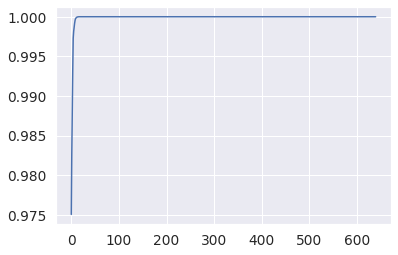

In [258]:
# Visualize
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)

In [259]:
#PCA Apply on 12 featues that explain all the variance 
pca = PCA(n_components = 12)
X_transform = pca.fit_transform(df)
print(X_transform.shape)

(2917, 12)


In [260]:
X = pd.DataFrame(X_transform)
pca_dict = []

for i in range(12):
    pca_name = 'PCA ' + str(i + 1)
    pca_dict.append(pca_name)
X.columns = pca_dict
X.index = df.index
X.head()

,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,PCA 7,PCA 8,PCA 9,PCA 10,PCA 11,PCA 12
0,-1689.415231,-34.973313,-218.676887,270.668211,-729.751311,-182.837423,-6.135665,78.945651,42.401486,-115.953635,-15.111615,-10.545092
1,-534.678694,78.071688,636.072452,-331.311326,-258.733601,-108.969435,27.974608,-63.111339,-109.245695,200.378804,17.783619,-26.638052
2,1110.957141,3.150641,-430.896868,267.657194,-420.136270,-173.145521,-15.871723,108.539571,-4.182532,-115.261443,-2.290232,-31.625632
3,-593.746980,-128.860460,-515.999337,285.715401,-176.908697,7.709412,41.194616,123.700915,-157.913398,-115.981041,202.143597,121.343525
4,4137.285796,511.577457,-591.025975,257.235453,-595.943062,-169.365118,-37.362993,268.865380,49.724527,25.050664,-5.093710,3.054630


# Training the model 

In [261]:
X_train = X[:1458]
X_test = X[1458:]
print(X_train.shape)
print(X_test.shape)
print(Y.shape)

(1458, 12)
(1459, 12)
(1458,)


Linear Regression

In [262]:
LR = LinearRegression()
LR.fit(X_train,Y)
Y_predict = LR.predict(X_train)
print( 'R_2 is :', (r2_score(Y,Y_predict))*100)
print( 'MAE:', (mean_absolute_error(Y,Y_predict))*100)

R_2 is : 76.61241273417251
MAE: 14.07443656001256


Random Forest Regressor

In [263]:
RF = RandomForestRegressor(n_estimators=100, max_depth = 10 )
RF.fit(X_train, Y)
Y_predict = RF.predict(X_train)
print( 'R_2 is :', (r2_score(Y,Y_predict))*100)
print( 'MAE:', (mean_absolute_error(Y,Y_predict))*100)

R_2 is : 94.61220429596011
MAE: 6.910710080620746


In [264]:
Y_predict = RF.predict(X_test)
submission = pd.DataFrame({'Id': Id, 'SalePrice': np.exp(Y_predict)})

In [265]:
submission.to_csv('SimpleAvg.csv', index=False)